# Experimentación con PCA
En este archivo estan los algoritmos construir las matrices, realizar PCA y el estudio de las eigenfaces

In [1]:
import math, subprocess
import pandas as pd
import numpy as np
import random, math
import os
import seaborn as sns
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Tiempo para armar el vector Z
tiempo_ZPCA = []
tiempo_Z2DPCA = []

# Tiempo para armar matriz Xc y covarianza
tiempo_XC = []
tiempo_aplanarX = []
tiempo_G = []
tiempo_ABAR = []

# Tiempo para reconstruir Z
tiempo_RZPCA = []
tiempo_RZ2DPCA = []

## Metodos base

In [3]:
def imprimir_matriz(A, folder, name):
    n = A.shape[0]
    
    if(not os.path.isdir("instancias")):
        os.mkdir("instancias")
        
    if(not os.path.isdir(F"instancias/{folder}")):
        os.mkdir(F"instancias/{folder}")
        
    if(not os.path.isdir(F"instancias/{folder}/{name}")):
        os.mkdir(F"instancias/{folder}/{name}")
        
    with open(F"instancias/{folder}/{name}/{name}.txt", "w") as f:
        print(n, file=f)
        for i in range(0, len(A)):
            for j in range(0, len(A)):
                print(A[i][j], file=f, end=" ")
            print(file=f, end="\n")

Ejecutar programa en C++ del método de la potencia
- carpeta: Carpeta donde se guarda la matriz
- nombre_matriz: Nombre de la cara
- iteraciones $\in \mathbf{N}$
- convergencia $\in \mathbf{R}$

In [4]:
def ejecutar_metodo(carpeta, nombre_matriz, iteraciones, convergencia):
    path = F"instancias/{carpeta}/{nombre_matriz}/{nombre_matriz}.txt"
    
    process = subprocess.Popen(
        ["./metodo_potencia", path, str(iteraciones), str(convergencia)], 
        stderr=subprocess.PIPE, 
        stdout=subprocess.PIPE, 
        stdin=subprocess.PIPE, 
        universal_newlines = True)
    exit_code = process.wait()
    if exit_code != 0: 
        print(F"Hubo un error en la experimentacion con la instancia {archivo_instancia}")
        
    process.stdin.close();
    process.stdout.close();
    process.stderr.close();

Leer la matriz por filas

In [5]:
def leer_matriz(path_instancia):
    matrix = np.loadtxt(path_instancia, dtype='d')
    return matrix

Se realiza la lectura de los autovalores y autovectores
- carpeta: Carpeta donde se guarda la matriz
- nombre_matriz: Nombre de la cara

In [6]:
def obtener_autovalores_autovectores(carpeta, nombre_matriz):
    path_gen = F"instancias/{carpeta}/{nombre_matriz}"
    eigenvalues = leer_matriz(F"{path_gen}/{nombre_matriz}.txt-autovalores.out")
    eigenvectors = leer_matriz(F"{path_gen}/{nombre_matriz}.txt-autovectores.out")
    return eigenvalues, eigenvectors

Obtenidos los autovalores y autovectores de la matriz de covarianza procedemos a la descoposición en autovalores y autovectores. $$C = VDV^t$$

In [7]:
def descomposicion(evalue, evector):
    n = evalue.shape[0]
    D = np.zeros((n,n))
    for i in range(0, len(evalue)):
        D[i,i] = evalue[i]

    VT = evector
    V = evector.T
    
    return V, D, VT

Definimos ``autovalores_autovectores`` como el método que recibe la carpeta, el nombre, la matriz C, las iteraciones y la tolerancia y se encarga de ejecutar el ``metodo_de_la_potencia(matriz, iteraciones, tolerancia)`` y nos devuelve la matriz C descompuesta. 

In [8]:
def autovalores_autovectores(fmatriz, nmatriz, cmatriz, iteraciones, tolerancia):
    imprimir_matriz(cmatriz, fmatriz, nmatriz)
    ejecutar_metodo(fmatriz, nmatriz, iteraciones, tolerancia)
    evalues, evectors = obtener_autovalores_autovectores(fmatriz, nmatriz)
    V, D, VT = descomposicion(evalues, evectors)
    return V, D, VT

## Armado de matrices

Para iniciar se leen todas las imagenes y se las guarda en un vector

In [9]:
paths = []
imgs = []
img_shape_y = 0
img_shape_x = 0
for path in sorted(list(Path('./instancias/caras').rglob('*/*.pgm'))):
    paths.append(path)
    #imgs.append(plt.imread(path))
    imgs.append(plt.imread(path)[::2,::2]/255)
X_IMG = np.stack(imgs)

In [10]:
img_shape_x = X_IMG.shape[2]
img_shape_y = X_IMG.shape[1]

Se definen los métodos de covarianza y correlación. Dados dos vectores $x$ e $y$:

Covarianza: $$Cov(x,y) = \frac{(x-\mu_x)(y-\mu_y)}{n-1}$$ con $\mu$ siendo el valor medio del vector.

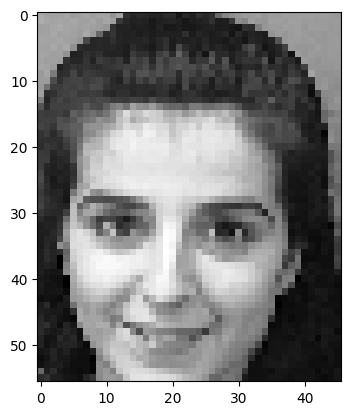

In [11]:
plt.imshow(X_IMG[10], cmap='gray');
plt.savefig("graficos/foto_persona.svg")

In [12]:
def covarianza(x, y):
    n = x.shape[0]
    sum_val = 0
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    for i in range(0, len(x)):
        sum_val += (x[i] - mu_x) * (y[i] - mu_y)
    cov = (1/(n-1))*sum_val
    return cov

Se define la correlación como una covarianza normalizada para que su rango esté entre $-1$ y $1$:

In [13]:
def correlacion(x, y):
    n = x.shape
    sum_num = 0
    sum_dem_a = 0
    sum_dem_b = 0
    
    # Se denota: sum_num / sqrt((sum_dem_a)(sum_dem_b))
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    
    for i in range(0, len(x)):
        op_x_mu = (x[i] - mu_x)
        op_y_mu = (y[i] - mu_y)

        sum_num += (op_x_mu)*(op_y_mu)
        sum_dem_a += (op_x_mu)**2
        sum_dem_b += (op_y_mu)**2
        
    sum_dem = (math.sqrt(sum_dem_a))*(math.sqrt(sum_dem_b))
    cor = 0
    if sum_dem != 0:
        cor = sum_num / sum_dem
    return cor

Alta correlación implica vectores paralelos. Con correlación positiva para vectores en la misma dirección y negativa en direcciones opuestas, y correlación nula implica vectores perpendiculares. $\\$
Por otro lado, si se consideran los vectores columna $x_i - \mu_{x_i}$ formando la matriz $X$, la covarianza entre todas las columnas se llama matriz de covarianza y se expresa como: $$C = \frac{X^TX}{n-1}$$

In [14]:
# Recibo la matriz y ejecuto el promedio y demás
def matriz_covarianza_calc(matriz):
    X = matriz.copy()
    m = len(X)
    n = len(X[0])
    mu = np.zeros(n)
    
    for i in range(0, n):
        suma = 0.0
        for j in range(0, m):
            suma = suma + X[j][i]
        suma = (suma / m)
        mu[i] = suma

    Xc = []
    for i in range(0, len(X)):
        Xc.append(X[i] - mu)
    Xc = np.array(Xc)
    XcT = Xc.T
    C = (Xc@XcT)/(n-1)
    return C

In [15]:
# Recibo la matriz y hago el producto y lo devuelvo
def matriz_covarianza(matriz):
    n = matriz.shape[1]
    C = (matriz.T@matriz)/(n-1)
    return C

Consideramos una matriz de datos $X \in R^{mxn}$..
Buscamos un cambio de base de tal manera que las dimensiones se ordenen en componetnes que expliquen la varianza en los datos de mayor a menor.
Usamos una descomposición en autovectores y autovalores de la matriz covarianza de los datos: $C = VDV^t$:
- $V$ es la matriz con los autovectores en las columnas. Permite transformar los datos de $X$ en la nueba base
- $D$ es una matriz diagonal con los autovalores.

Entonces, aplicamos el método de la potencia a la matriz C para obtener su descomposición.

Hasta este punto tenemos: $V, D, V^t, X, C$. Como $V$ permite transformar los datos de $X$ en la nueva base, definimos $R = XV$ como esta rotación.

In [16]:
def construir_R(X, V):
    R = X@V
    return R

Dependiendo la situación, se puede reducir la dimensionaldiad de los datos utilizando solo las $k$ componentes principales deseadas. (Usando los primeros $k$ vectores columna de la matriz $V$.
En nuestra implementación, podemos enviar al método ```autovalores_autovectores``` el $k$ deseado y tomamos las primeras $k$ filas de la lectura de nuestro archivo de autovalores y autovectores

### Analisis de componentes principales aplicado al conjunto de imagenes

Considerando $x_i \in \mathbf{R}^n$ a la i-esima imagen de la base almacenada como un vector de largo $n$ la cantidad de pixeles.
Se pueden apilar todas las imagenes como filas en una matriz $X \in \mathbf{R}^{mxn}$.
Sea $\mu_j = \sum_{i-1}^m X_{ij}/m$ el promedio de cada dimensión-pixel de las imagenes.
Se define la matriz $X_c$ que contiene en la i-esima fila al vector $(x_i - \mu)^t)$ y $C = X_c^tX_c/(n-1)$ la matriz de covarianza.
Se define la imagen $x_i$ proyectada en el espacio de menor dimensión como el vector $z_i = (u_1^tx_i, u_2^tx_i,\dots,u_k^tx_i) \in \mathbf{R}^k$ donde $u_j$ es el autovector de $C$ asociado al j-esimo autovalor y, al ser ordenados de mayor a menor y $k$ define cuantas componentes se utilizan.$\\$
En forma matricial $z_i = x_iVk$ donde $Vk$ se obtiene a partir de las primeras $k$ columnas de $V$ la matriz de autovectores.

Para fines de este trabajo, se toma la imagen y se la "estira", es decir, si la imagen es una matriz $A$, se costruye el vector $X = [A_1, A_2, \dots, A_n]$ que resulta ser la fila 1 de $A$ seguida de la fila 2 de $A$ y así consecutivamente.

In [17]:
# Construimos la matriz X
def construir_X_PCA(IMAGES):
    X = []
    tiempo = 0.0
    
    for i in range(0, len(IMAGES)):
        start_time = time.time()
        x_i = []
        for j in range(0, len(IMAGES[i])):
            for k in range(0, len(IMAGES[i][j])):
                x_i.append(IMAGES[i][j][k])
        X.append(x_i)
        tiempo = tiempo + (time.time() - start_time)
        tiempo_aplanarX.append(tiempo)
    
    X = np.array(X)
    m = X.shape[0]
    n = X.shape[1]
    
    return X, m, n

In [18]:
# Matriz estirada
X_PCA, m_pca, n_pca = construir_X_PCA(X_IMG)

In [19]:
# Construimos el vector mu
def construir_mu_PCA(X, n, m):
    mu = np.zeros(n)
    
    for i in range(0, n):
        sum = 0.0
        for j in range(0, m):
            sum = sum + X[j][i]
        sum = (sum / m)
        mu[i] = sum
        
    return mu

In [20]:
MU = construir_mu_PCA(X_PCA, n_pca, m_pca)

In [21]:
# Construimos Xc a partir de X y de mu
def construir_X_c_PCA(X, mu):
    Xc = []
    tiempo = 0.0
    for i in range(0, len(X)):
        start_time = time.time()
        Xc.append(X[i] - mu)
        tiempo = tiempo + (time.time() - start_time)
        tiempo_XC.append(tiempo)
    Xc = np.array(Xc)
    return Xc

In [22]:
Xc = construir_X_c_PCA(X_PCA, MU)

In [23]:
# Obtenemos la matriz de covarianza
C = matriz_covarianza(Xc)

In [24]:
# Ahora buscamos los autovalores y autovectores
#V_PCA, D_PCA, VT_PCA = autovalores_autovectores("PCA", "PCA", C, 10000, 0.000001)

In [25]:
# Leemos los valores sin volver a ejecutar el método de la potencia.
evalues, evectors = obtener_autovalores_autovectores("PCA", "PCA")
V_PCA, D_PCA, VT_PCA = descomposicion(evalues, evectors)

In [26]:
def obtener_z_pca(X, VT, K_VALUE):
    # Definimos el vector z
    VTK = VT[:K_VALUE]
    ZT = []
    tiempo = 0.0
    for i in range(0, len(X)):
        start_time = time.time()
        zi = VTK @ X[i]
        ZT.append(zi)
        tiempo = tiempo + (time.time() - start_time)
        tiempo_ZPCA.append(tiempo)
    return np.array(ZT)

In [27]:
Z_PCA = obtener_z_pca(X_PCA, VT_PCA, len(VT_PCA))

### Analisis 2DPCA

Consideramos ahora, dada el conjunto de imagenes, $A \in \mathbf{R}^{(axb)}$ y $A \in IMG$ como una imagen y, un vector $Y \in \mathbf{R}^a$ tal que podamos realizar la transformación lineal $Y = AX$ siendo $X \in R^b$ el vector que maximiza la dispersión de los features vectores. Una elección óptima para el $X$ corresponde al autovector asociado al máximo autovalor. Sea: $$G = \frac{1}{n}\sum_{j=1}^n(A_j-\bar{A})^T(A_j-\bar{A})$$ con $\bar{A}$ la imagen promedio del conjunto de imagenes. El tamaño de la matriz resulta menor que la de la covarianza asociada en PCA.

Sea $j$ el indice que recorre cada imagen, lo primero que hacemos es buscar $\bar{A}$ y luego operamos con cada una de las matrices. Sea $n$ la cantidad de imagenes

In [28]:
# Obtenemos las variables necesarias
image_size = X_IMG[0].shape
image_quantity = len(X_IMG)

Obtención de $\bar{A}$

In [29]:
# Construimos A_BARRA
def obtener_A_barra(IMG_ARR, size, quantity):
    A = np.zeros(size)
    tiempo = 0.0
    for i in range(0, quantity):
        start_time = time.time()
        A = A + IMG_ARR[i]
        tiempo = tiempo + (time.time() - start_time)
        tiempo_ABAR.append(tiempo)
    A = A / image_quantity
    return A

In [30]:
A_BAR = obtener_A_barra(X_IMG, image_size, image_quantity)

Obtención de $G$

In [31]:
# Construimos G
def construir_G(A_barra, IMG_ARR, size, quantity):
    G = np.zeros((size, size))
    tiempo = 0.0
    for j in range(0, quantity):
        start_time = time.time()
        A_RESTA = IMG_ARR[j] - A_BAR
        A_RES = ((A_RESTA).T) @ A_RESTA
        G = G + A_RES
        tiempo = tiempo + (time.time() - start_time)
        tiempo_G.append(tiempo)
    G = G / image_quantity
    return G

In [32]:
G = construir_G(A_BAR, X_IMG, image_size[1], image_quantity)

Ahora procedemos a calcular los autovalores y autovectores de G

In [33]:
#V_G, D_G, VT_G = autovalores_autovectores("2DPCA", "2DPCA", G, 10000, 0.000001)

In [34]:
evalues, evectors = obtener_autovalores_autovectores("2DPCA", "2DPCA")
V_G, D_G, VT_G = descomposicion(evalues, evectors)

Ahora nos toca realizar la evaluación Y = AX.

In [35]:
def conseguir_V(EIGENVECTORS, IMG):
    V = []
    A = IMG
    for k in range(0, len(EIGENVECTORS)):
        Y_k = A @ EIGENVECTORS[K]
        V.append(np.array(Y_k))
    V = np.array(V)
    V = V.T
    # U y V tienen como fila los vectores Y1...YB y X1...XB respectivamente
    return V

In [36]:
def armar_U(EIGENVECTORS):
    U = []
    for k in range(0, len(EIGENVECTORS)):
        X_k = EIGENVECTORS[k]
        U.append(np.array(X_k))
    U = np.array(U)
    U = U.T
    # U y V tienen como fila los vectores Y1...YB y X1...XB respectivamente
    return U

In [37]:
U = armar_U(VT_G)

Obtenidas las matrices $V$ y $U$, sabemos que $V = AU$, $A = UV^T$. A su vez: $$A = VU^T = \sum_{j=1}^{b}Y_jX_j^T$$ donde cada $Y_jX_j^T$ es una subimagen de $A$.
Para calcular la representación en baja dimensionalidad de $A_i$ computamos $Z_i = (A_iX_1, A_iX_2,\dots,A_iX_k) \in \mathbf{R}^{axk}$ donde $A_iX_k$ represeta el k-esimo vector de la imagen $A_i$

In [38]:
def obtener_z_2dpca(IMAGES, U, img_qnt, K_VALUE):
    # Recorremos todas las imagenes
    Z = [] 
    UK = (U.T[:K_VALUE]).T
    tiempo = 0.0
    for i in range(0, img_qnt):
        start_time = time.time()
        V = IMAGES[i] @ U
        Z.append(V)
        tiempo = tiempo + (time.time() - start_time)
        tiempo_Z2DPCA.append(tiempo)
    return np.array(Z)

In [39]:
Z_2DPCA = obtener_z_2dpca(X_IMG, U, image_quantity, len(U))

## Analisis de los resultados obtenidos

In [40]:
EIGEN_PCA = []
for i in range(0, len(D_PCA)):
    EIGEN_PCA.append(D_PCA[i][i])
EIGEN_PCA = np.array(EIGEN_PCA)

In [41]:
EIGEN_2DPCA = []
for i in range(0, len(D_G)):
    EIGEN_2DPCA.append(D_G[i][i])
EIGEN_2DPCA = np.array(EIGEN_2DPCA)

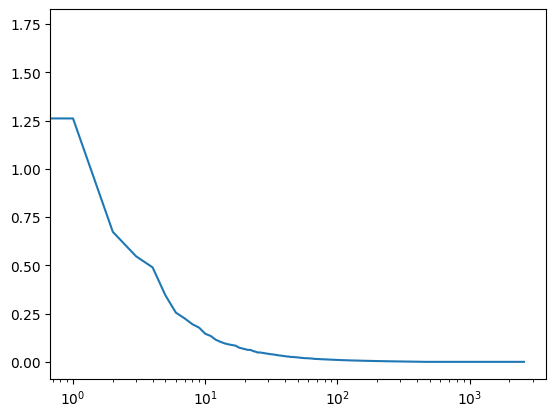

In [42]:
plt.plot(EIGEN_PCA)
plt.xscale("log")
plt.savefig("graficos/eigenvalues_pca.svg")

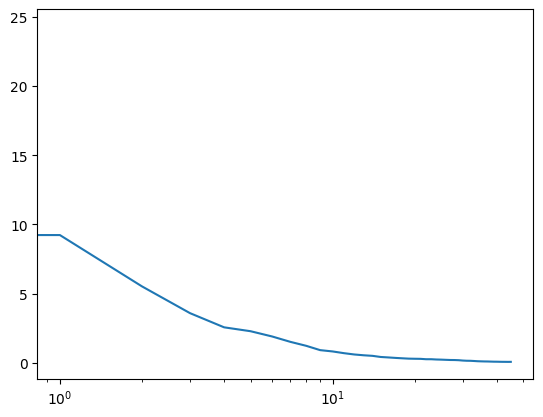

In [43]:
plt.plot(EIGEN_2DPCA)
plt.xscale("log")
plt.savefig("graficos/eigenvalues_2dpca.svg")

## Matriz de cambio de base

In [44]:
def calcular_CB(autovectores):
    CBT = autovectores
    CB = autovectores.T
    return CB, CBT

## Transformación característica - PCA

Tenemos $X \in \mathbf{R}^{nxm}$ donde cada fila es una imagen estirada. Si queremos realizar un cambio de base entonces dada una instancia, encotnramos sus coordenadas usando $C_{B,E}^T = V^T$ tal que: $$\bar{Z}_{X} = V^Tx$$Si queremos cambiar de base cada instancia. $V^TX^T = V^T[x^{(1)} \dots x^{(n)}] = [V^Tx^{(1)} \dots V^Tx^{(n)}]$
Y para que cada imagen esté en una fila, transponemos:
$$Z_X = (V^TX^T)^T = XV$$

Para reconstruir la imagen:
- Hay que reescribir a cada imagen en el espacio de PCA.
- Dada una imagen $x, Z_x \in \mathbf{R}^m$ son las coordenadas en la base de autovectores $V$.
- Entonces reconstruyo $x=  \sum_{i=0}^{m}Z_x^i V_i$
- Si tomamos $k \leq m$ tenemos $x \approx \sum_{i=0}^k Z_x^i V_i$

In [45]:
def reconstruir_PCA(K_VALUE, Z_PCA, VT):
    X_PCA_IMG = []
    start_time = time.time()
    
    if K_VALUE <= len(VT):
        for index in range(0, len(Z_PCA)):
            Zx = Z_PCA[index]
            suma = np.zeros(VT[0].shape)
            for i in range(0, K_VALUE):
                suma = suma + (Zx[i] * VT[i])
            X_PCA_IMG.append(suma)
            
    tiempo = time.time() - start_time
    tiempo_RZPCA.append(tiempo)
    
    return np.array(X_PCA_IMG)

In [46]:
# X_PCA_IMG = reconstruir_PCA(400, Z_PCA, VT_PCA)

In [47]:
component = 500
skip = 100
size = 20
img_selected = 10
reconstructed_img = []

titles = []
for loop in range(size):
    titles.append(str(component))
    component += skip
    
component = 500
for i in range(0, size):
    X_PCA_IMG = reconstruir_PCA(component, Z_PCA, VT_PCA)
    IMG_RESHAPE = X_PCA_IMG[img_selected].reshape((img_shape_y, img_shape_x))
    reconstructed_img.append(IMG_RESHAPE)
    component += skip

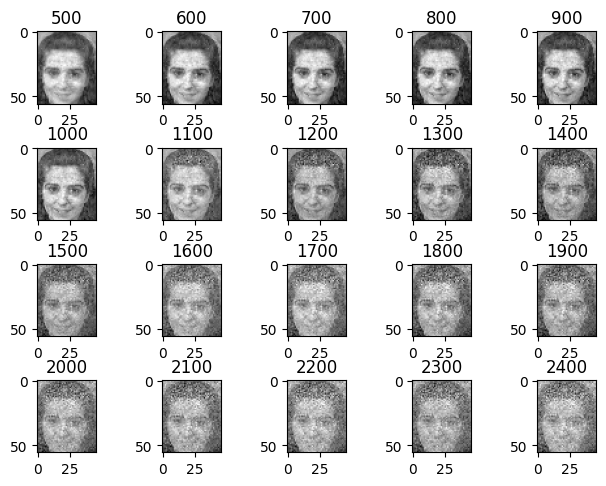

In [48]:
fig, axs = plt.subplots(4, 5)
index = 0
fig.tight_layout()
for i in range(0, 4):
    for j in range(0, 5):
        axs[i,j].imshow(reconstructed_img[index], cmap='gray')
        axs[i,j].set_title(titles[index])
        index += 1
plt.savefig("graficos/persona_reconstruccion_pca.svg");
plt.show()

## Transformación característica - 2DPCA

Sea $A \in R^{axa}$ imagen y $X \in R^a$
Buscamos proyección $Y = AX$ tal que aplicada a toda la base de imágenes $$argmax J(X) = Tr(S_x)$$
donde $S_x = E(Y - \bar{Y})(Y - \bar{Y})^T$ la _image covariance matrix_ <br>
$S_x$ contiene un subconjunto de las covarianzas de la PCA. <br>
Se puede ver que $Tr(S_x) = X^TGX$ con $G = \sum^N_{j = 1} (A_j - \hat{A})(A_j - \hat{A})^T $ <br>
Lo anterior se maximiza tomando $X$ como el autovector dominante de $G$. <br>

Para tal motivo:
- Definimos $V = (Y_1 | Y_2 | \dots | Y_a)$ y $U = (X_1 | X_2 | \dots | X_a)$
- Notar que $V = AU$. Por ser $U$ ortonormal $A = VU^T$ permite recuperar A.
- $VU^T = \sum_{j=1}^a Y_j X_j^T$ por propiedad de multiplicación matricial.
- Si tomamos $k \geq a$ tenemos $A \approx \sum_{j=1}^k Y_j X_j^T$
- Equivalentemente, $A \approx VU_k^T$ con $U_k$ las primeras $k$ columnas de $U$.

In [49]:
def reconstruir_2DPCA(K_VALUE, Z_2DPCA, U, X_IMG):
    X_2DPCA_IMG = []
    start_time = time.time()
    
    if K_VALUE <= len(U):      
        for i in range(0, len(Z_2DPCA)):
            V = Z_2DPCA[i]
            imagen = np.zeros(X_IMG.shape)
            VT = V.T
            UT = U.T
            for j in range(0, K_VALUE):
                VTAUX = np.matrix(VT[j])
                UTAUX = np.matrix(UT[j])
                imagen = imagen + (VTAUX.T) * UTAUX
            X_2DPCA_IMG.append(imagen)

    tiempo = time.time() - start_time
    tiempo_RZ2DPCA.append(tiempo)
    return np.array(X_2DPCA_IMG)

In [50]:
X_2DPCA_IMG =reconstruir_2DPCA(20, Z_2DPCA, U, X_IMG[0])

In [51]:
component = 2
skip = 2
size = 20
img_selected = 10
reconstructed_img_2dpca = []

titles = []
for loop in range(size):
    titles.append(str(component))
    component += skip
    
component = 2
for i in range(0, size):
    IMG_RECONSTRUCTED = reconstruir_2DPCA(component, Z_2DPCA, U, X_IMG[0])
    reconstructed_img_2dpca.append(IMG_RECONSTRUCTED[img_selected])
    component += skip

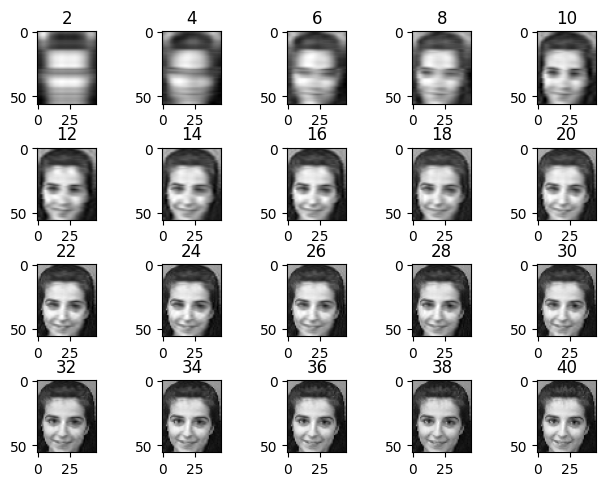

In [52]:
fig, axs = plt.subplots(4, 5)
index = 0
fig.tight_layout()
for i in range(0, 4):
    for j in range(0, 5):
        axs[i,j].imshow(reconstructed_img_2dpca[index], cmap='gray')
        axs[i,j].set_title(titles[index])
        index += 1
plt.savefig("graficos/persona_reconstruccion_2dpca.svg");
plt.show()

# Graficos de matriz de similaridad

Dado un conjunto de datos $X \in R^{mxn}$ con $m$ datos y $n$ atributos, se define una matriz de similaridad a una matriz de $\mathbf{R}^{mxm}$ que computa una función sobre cada par de datos ij. $$D_{ij} = f(X_i,X_j)$$
La similaridad que vamos a utilizar viene dada por la matriz de correlación $R$ a partir de la de covarianza.
$$C = \frac{X_cX_c^t}{n-1}$$ $$R_{ij}=\frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}}$$

In [63]:
def matriz_correlacion(C):
    R = np.zeros(C.shape)
    for i in range(0, len(C)):
        for j in range(0, len(C[i])):
            R[i][j] = C[i][j] / np.sqrt(C[i][i] * C[j][j])
    return R

In [54]:
C_original = matriz_covarianza_calc(X_PCA)
R_original = matriz_correlacion(C_original)

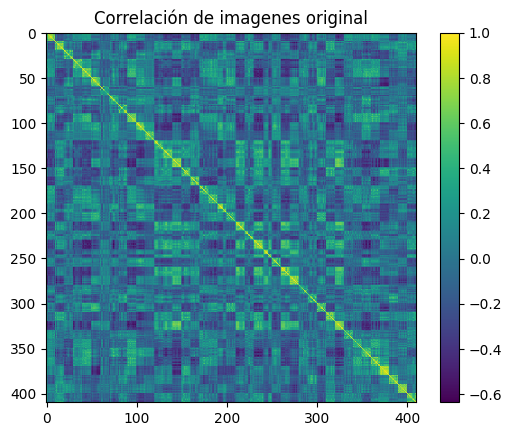

In [55]:
plt.imshow(R_original)
plt.colorbar()
plt.title("Correlación de imagenes original")
plt.savefig("graficos/correlacion_imagenes_estiradas.svg")
plt.show()

In [56]:
#R_2DPCA = matriz_correlacion(G)
#plt.imshow(R_2DPCA)
#plt.colorbar()

### Analisis de correlación para PCA

In [57]:
K_PCA_1 = 100
K_PCA_2 = 900
K_PCA_3 = 1800
X_PCA_IMG_1 = reconstruir_PCA(K_PCA_1, Z_PCA, VT_PCA)
X_PCA_IMG_2 = reconstruir_PCA(K_PCA_2, Z_PCA, VT_PCA)
X_PCA_IMG_3 = reconstruir_PCA(K_PCA_3, Z_PCA, VT_PCA)

In [58]:
PCA_COV_1 = matriz_covarianza_calc(X_PCA_IMG_1)
PCA_COV_2 = matriz_covarianza_calc(X_PCA_IMG_2)
PCA_COV_3 = matriz_covarianza_calc(X_PCA_IMG_3)

In [59]:
R_PCA_1 = matriz_correlacion(PCA_COV_1)
R_PCA_2 = matriz_correlacion(PCA_COV_2)
R_PCA_3 = matriz_correlacion(PCA_COV_3)

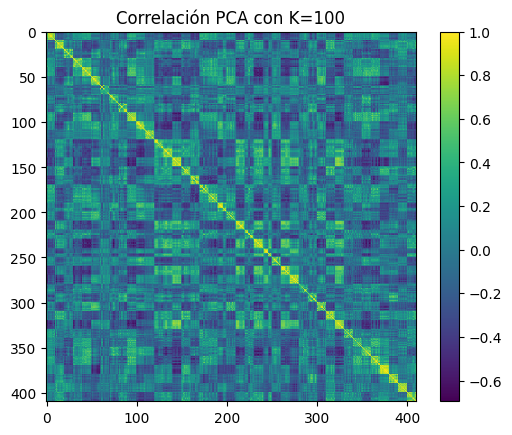

In [60]:
plt.imshow(R_PCA_1)
plt.colorbar()
plt.title("Correlación PCA con K=100")
plt.savefig("graficos/correlacion_k_pca_100.svg")
plt.show()

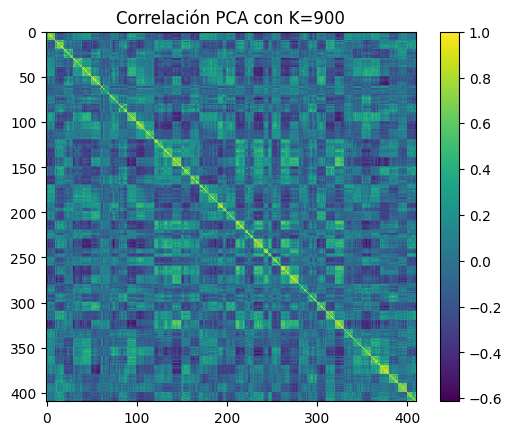

In [61]:
plt.imshow(R_PCA_2)
plt.colorbar()
plt.title("Correlación PCA con K=900")
plt.savefig("graficos/correlacion_k_pca_900.svg")
plt.show()

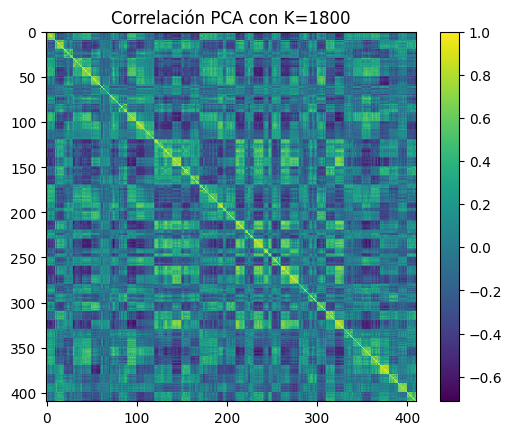

In [62]:
plt.imshow(R_PCA_3)
plt.colorbar()
plt.title("Correlación PCA con K=1800")
plt.savefig("graficos/correlacion_k_pca_1800.svg")
plt.show()

### Analisis de correlación para 2DPCA

In [64]:
# APLANAMOS Z_2DPCA
def aplanar_Z_2DPCA(Z_AUX):
    Z_FLATTEN = []
    for m in range(0, len(Z_AUX)):
        flattened = []
        for i in range(0, len(Z_AUX[m])):
            for j in range(0, len(Z_AUX[m][i])):
                flattened.append(Z_AUX[m][i][j])
        Z_FLATTEN.append(np.array(flattened))
    return np.array(Z_FLATTEN)

In [65]:
K_2DPCA_1 = 10
K_2DPCA_2 = 40

In [66]:
X_2DPCA_IMG_1 = reconstruir_2DPCA(K_2DPCA_1, Z_2DPCA, U, X_IMG[0])
X_2DPCA_IMG_2 = reconstruir_2DPCA(K_2DPCA_2, Z_2DPCA, U, X_IMG[0])

In [67]:
Z_2DPCA_FLATTEN_1 = aplanar_Z_2DPCA(X_2DPCA_IMG_1)
Z_2DPCA_FLATTEN_2 = aplanar_Z_2DPCA(X_2DPCA_IMG_2)

In [68]:
DPCA_COV_1 = matriz_covarianza_calc(Z_2DPCA_FLATTEN_1)
DPCA_COV_2 = matriz_covarianza_calc(Z_2DPCA_FLATTEN_2)

In [69]:
R_2DPCA_1 = matriz_correlacion(DPCA_COV_1)
R_2DPCA_2 = matriz_correlacion(DPCA_COV_2)

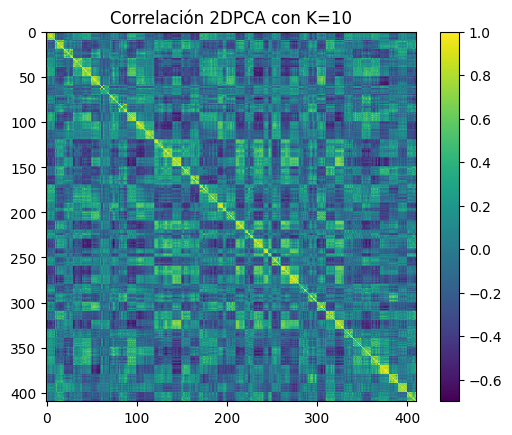

In [70]:
plt.imshow(R_2DPCA_1)
plt.colorbar()
plt.title("Correlación 2DPCA con K=10")
plt.savefig("graficos/correlacion_k_2dpca_10.svg")
plt.show()

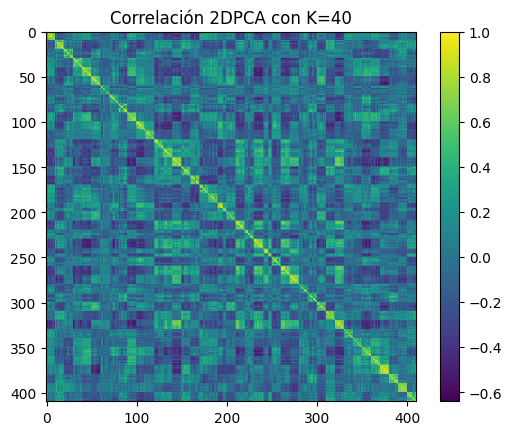

In [71]:
plt.imshow(R_2DPCA_2)
plt.colorbar()
plt.title("Correlación 2DPCA con K=40")
plt.savefig("graficos/correlacion_k_2dpca_40.svg")
plt.show()

## Tiempo de ejecución de los algoritmos

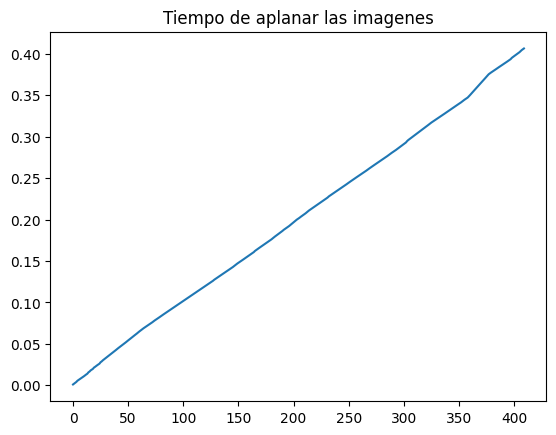

In [72]:
# Tiempo para aplanar las imagenes
plt.plot(tiempo_aplanarX)
plt.title("Tiempo de aplanar las imagenes")
plt.savefig("graficos/tiempo_aplanar_imagenes.svg")
plt.show()

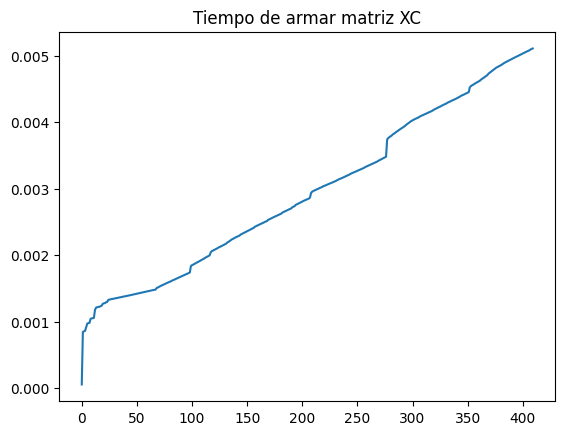

In [73]:
# Tiempo para armar la matrix Xc
plt.plot(tiempo_XC)
plt.title("Tiempo de armar matriz XC")
plt.savefig("graficos/tiempo_armar_XC.svg")
plt.show()

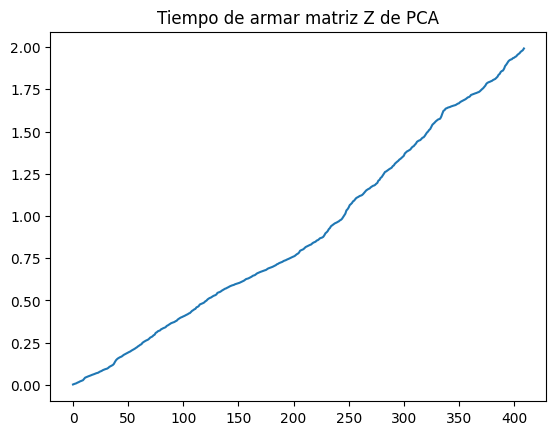

In [74]:
# Tiempo para armar la matriz Z de PCA
plt.plot(tiempo_ZPCA)
plt.title("Tiempo de armar matriz Z de PCA")
plt.savefig("graficos/tiempo_armar_ZPCA.svg")
plt.show()

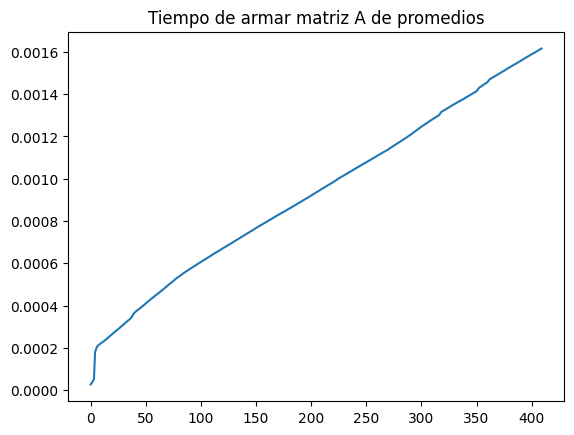

In [75]:
# Tiempo para armar la matriz Z de 2DPCA
plt.plot(tiempo_ABAR)
plt.title("Tiempo de armar matriz A de promedios")
plt.savefig("graficos/tiempo_armar_ABAR.svg")
plt.show()

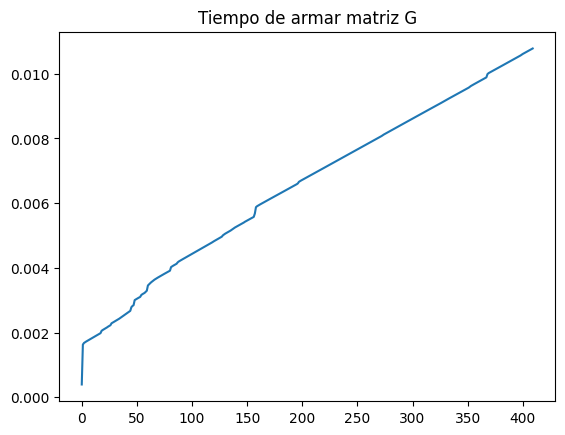

In [76]:
# Tiempo para armar la matriz Z de PCA
plt.plot(tiempo_G)
plt.title("Tiempo de armar matriz G")
plt.savefig("graficos/tiempo_armar_G.svg")
plt.show()

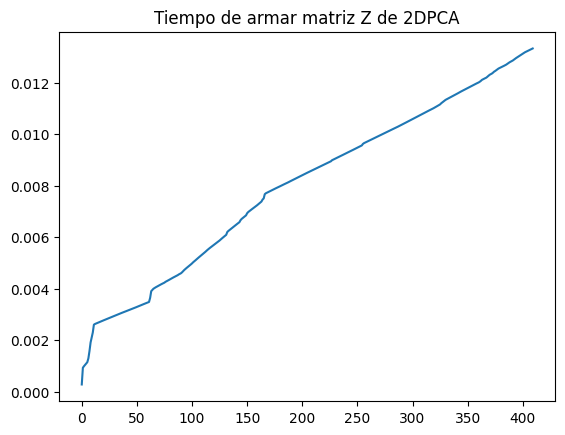

In [77]:
# Tiempo para armar la matriz Z de PCA
plt.plot(tiempo_Z2DPCA)
plt.title("Tiempo de armar matriz Z de 2DPCA")
plt.savefig("graficos/tiempo_armar_Z2DPCA.svg")
plt.show()

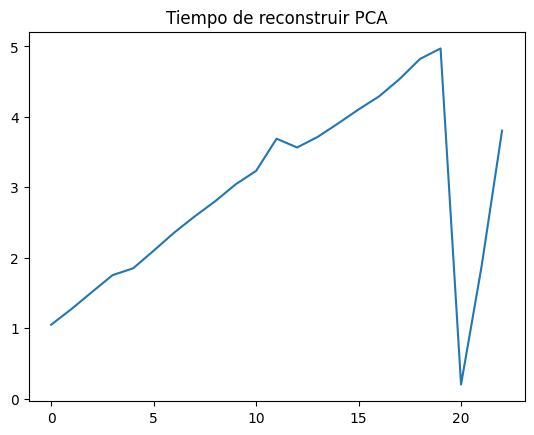

In [78]:
plt.plot(tiempo_RZPCA)
plt.title("Tiempo de reconstruir PCA")
plt.savefig("graficos/tiempo_reconstruir_PCA.svg")
plt.show()

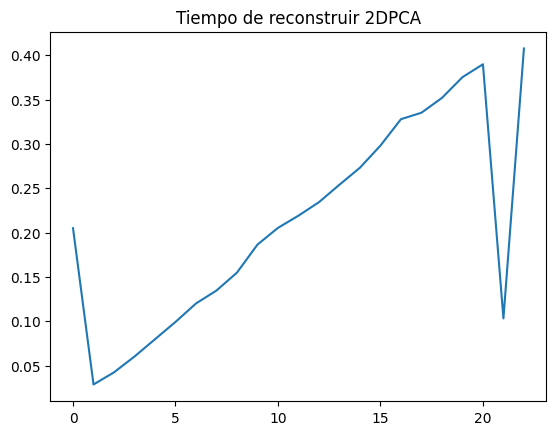

In [79]:
plt.plot(tiempo_RZ2DPCA)
plt.title("Tiempo de reconstruir 2DPCA")
plt.savefig("graficos/tiempo_reconstruir_2DPCA.svg")
plt.show()

## Analisis de Similaridad

## Analisis de PCA

In [80]:
# Creamos el arreglo donde se guardarán los datos y los K que vamos a usar
SIM_PCA = []
sample_K = (np.arange(50, 2650, 50).tolist())

In [81]:
# Iniciamos el método
for k in sample_K:
    ZK = obtener_z_pca(X_PCA, VT_PCA, k)
    #get_COV_PCA = (ZK@ZK.T)/((ZK.shape[1])-1)
    get_COV_PCA = matriz_covarianza_calc(ZK)
    get_R_PCA = matriz_correlacion(get_COV_PCA)
    SIM_PCA.append(get_R_PCA) 
SIM_PCA = np.array(SIM_PCA)

In [82]:
SIM_PCA_AUX = SIM_PCA.copy()

In [83]:
prom_mismos = []
prom_distintos = []

In [84]:
for k in range(0, len(SIM_PCA)):
    k_range = 10
    salto = 10
    PROM_MISMO = np.zeros((salto,salto))
    PROM_DISTINTO = np.zeros((salto, len(SIM_PCA[0])))
    
    for j in range(0, 41):
        CUBE = []
        CUBE_EXTEND = []
        
        range_min = k_range*j
        range_max = range_min + salto
        
        K_MAT = SIM_PCA_AUX[k]
        RECTANGLE = K_MAT[range_min:range_max]
    
        for i in range(0, len(RECTANGLE)):
            CUBE.append((K_MAT[i][range_min:range_max]) / 4100)
            CUBE_EXTEND.append(K_MAT[i] / 4100)
            
        for i in range(0, len(CUBE_EXTEND)):
            for l in range(range_min,range_max):
                CUBE_EXTEND[i][l] = 0
                        
        CUBE = np.array(CUBE)
        CUBE_EXTEND = np.array(CUBE_EXTEND)
        
        PROM_MISMO = PROM_MISMO + CUBE
        PROM_DISTINTO = PROM_DISTINTO + CUBE_EXTEND
        
        
    sum_mismo = PROM_MISMO.sum()
    sum_distinto = PROM_DISTINTO.sum()
    
    prom_mismos.append(sum_mismo)
    prom_distintos.append(sum_distinto)

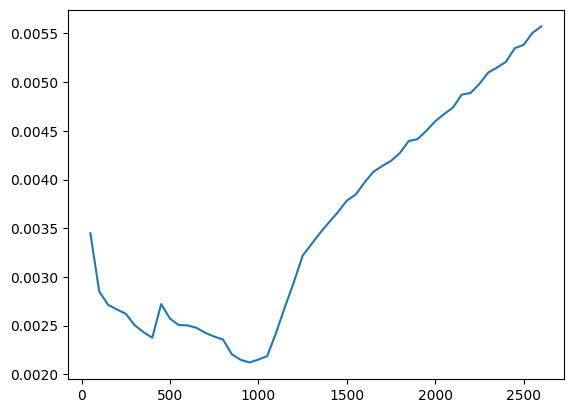

In [85]:
fig, ax = plt.subplots()
ax.plot(sample_K, prom_mismos)
plt.savefig("graficos/sim_mismos_PCA_aux.svg")
plt.show()

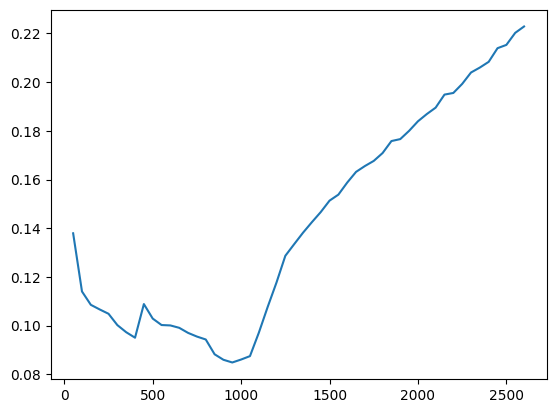

In [86]:
fig, ax = plt.subplots()
ax.plot(sample_K, prom_distintos)
plt.savefig("graficos/sim_distintos_PCA_aux.svg")
plt.show()

### Veo las metricas

Se que cada persona tiene 10 imagenes. Entonces puedo tomar cuadrados de 10x10 que son la información de cada persona.

## Analisis de 2DPCA

In [87]:
# Creamos el arreglo donde se guardarán los datos y los K que vamos a usar
SIM_2DPCA = []
sample_2DPCPA_K = np.random.randint(1, 45, 40)
sample_2DPCPA_K = np.sort(sample_2DPCPA_K)

In [88]:
# Iniciamos el método
for k in sample_K:
    Z2DPCAK = obtener_z_2dpca(X_IMG, U, image_quantity, k)
    Z_APLANADO = aplanar_Z_2DPCA(Z2DPCAK)
    get_COV_2DPCA = (Z_APLANADO@Z_APLANADO.T)/((Z_APLANADO.shape[1])-1)
    get_R_2DPCA = matriz_correlacion(get_COV_2DPCA)
    SIM_2DPCA.append(get_R_2DPCA) 
SIM_2DPCA = np.array(SIM_2DPCA)

In [89]:
SIM_2DPCA_AUX = SIM_2DPCA.copy()

In [90]:
prom_mismos = []

In [91]:
for k in range(0, len(SIM_2DPCA_AUX)):
    k_range = 10
    salto = 10
    PROM_MISMO = np.zeros((salto,salto))
    
    for j in range(0, 41):
        CUBE = []
        
        range_min = k_range*j
        range_max = range_min + salto
        
        K_MAT = SIM_2DPCA_AUX[k]
        RECTANGLE = K_MAT[range_min:range_max]
    
        for i in range(0, len(RECTANGLE)):
            CUBE.append((K_MAT[i][range_min:range_max]) / 410)
            
        CUBE = np.array(CUBE)
        PROM_MISMO = PROM_MISMO + CUBE
        
    sum_mismo = PROM_MISMO.sum()
    prom_mismos.append(sum_mismo)

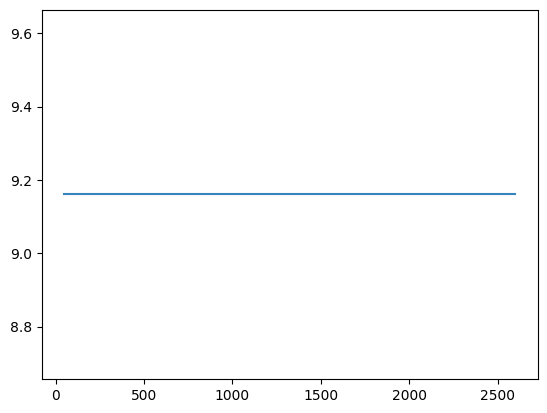

In [92]:
fig, ax = plt.subplots()
ax.plot(sample_K, prom_mismos, alpha=0.9)
plt.show()

## Metricas y Normas

Para esta parte usaremos la Norma Frobenius para el analisis de toda la matriz

In [93]:
def norma_frobenius(A):
    m = A.shape[0]
    n = A.shape[1]
    norma_f = 0.0
    for i in range(0, m):
        for j in range(0, n):
            norma_f = norma_f + ((A[i][j])**2)
    norma_f = math.sqrt(norma_f)
    return norma_f

## Analisis en PCA

In [94]:
def obtener_z_pca_sin_I(X, VT, K_VALUE, IMG_RMV):
    IMG_RMV_MIN = IMG_RMV * 10
    IMG_RMV_MAX = (IMG_RMV * 10) + 10
    VTK = VT[:K_VALUE]
    ZT = []
    for i in range(0, len(X)):
        if(i < IMG_RMV_MIN or i >= IMG_RMV_MAX):
            zi = VTK @ X[i]
            ZT.append(zi)
    return np.array(ZT)

In [95]:
normas_PCA = []
sample_rmv_PCA = [-5,0,5,10,15,20,25,30,35,40]

In [96]:
for srmv in sample_rmv_PCA:
    Z_PCA_AUX = obtener_z_pca_sin_I(X_PCA, VT_PCA, len(VT_PCA), srmv)
    norma_z_aux = norma_frobenius(Z_PCA_AUX)
    normas_PCA.append(norma_z_aux)

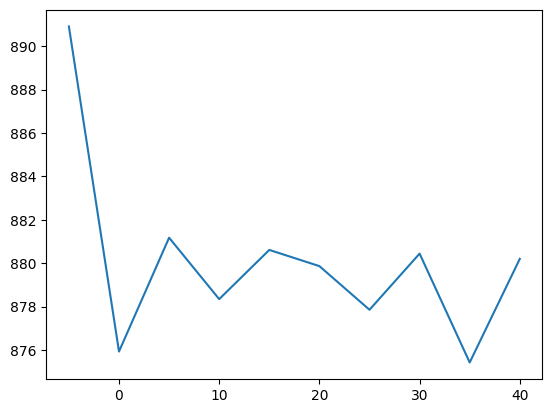

In [102]:
plt.plot(sample_rmv_PCA, normas_PCA)
plt.savefig("graficos/normas_PCA.svg")
plt.show()

In [100]:
IMG_RMV = sample_rmv_PCA[4]
Z_RMV = obtener_z_pca_sin_I(X_PCA, VT_PCA, len(VT_PCA), IMG_RMV)
X_PCA_RMV_IMG = reconstruir_PCA(900, Z_RMV, VT_PCA)

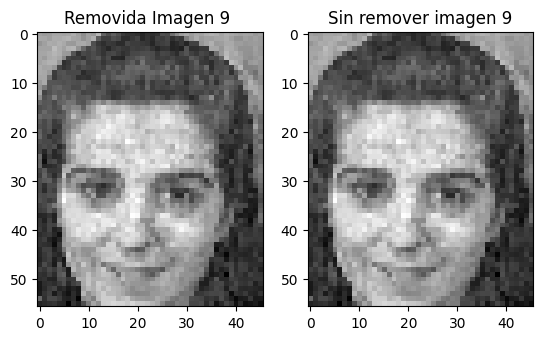

In [104]:
IMG_RESHAPE_RMV = X_PCA_RMV_IMG[10].reshape((img_shape_y, img_shape_x))

fig, axs = plt.subplots(1, 2)

axs[0].imshow(IMG_RESHAPE_RMV, cmap='gray')
axs[0].set_title("Removida Imagen 9 ")

axs[1].imshow(reconstructed_img[4], cmap='gray')
axs[1].set_title("Sin remover imagen 9")

plt.savefig("graficos/reconstrucción_removida_PCA.svg")
plt.show()

## Analisis en 2DPCA

In [105]:
def obtener_z_2dpca_sin_I(IMAGES, U, img_qnt, K_VALUE, IMG_RMV):
    # Recorremos todas las imagenes
    Z = [] 
    UK = (U.T[:K_VALUE]).T
    for i in range(0, img_qnt):
        if(i != IMG_RMV):
            V = IMAGES[i] @ U
            Z.append(V)
    return np.array(Z)

In [106]:
normas_2DPCA = []
sample_rmv_2DPCA = [-5,0,5,10,15,20,25,30,35,40]

In [107]:
for i in range(0, len(sample_rmv_2DPCA)):
    IMG_RMV = sample_rmv_2DPCA[i]
    Z_2DPCA_AUX = obtener_z_2dpca_sin_I(X_IMG, U, image_quantity, len(U), IMG_RMV)
    Z_2DPCA_APL = aplanar_Z_2DPCA(Z_2DPCA_AUX)
    norma_z_aux = norma_frobenius(Z_2DPCA_APL)
    normas_2DPCA.append(norma_z_aux)

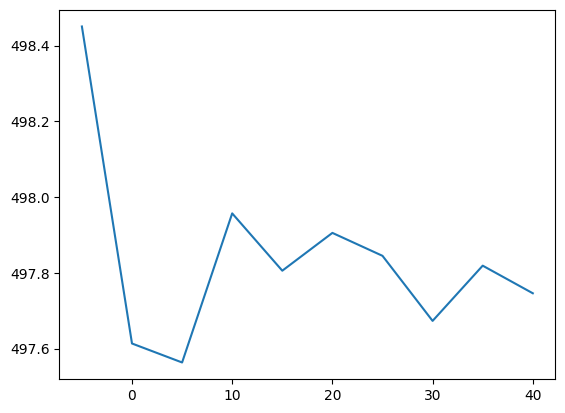

In [108]:
plt.plot(sample_rmv_2DPCA, normas_2DPCA)
plt.savefig("graficos/normas_2DPCA.svg")
plt.show()

In [110]:
IMG_RMV = sample_rmv_2DPCA[4]
Z_RMV = obtener_z_2dpca_sin_I(X_IMG, U, image_quantity, len(U), IMG_RMV)
X_PCA_RMV_IMG = reconstruir_2DPCA(40, Z_2DPCA, U, X_IMG[0])

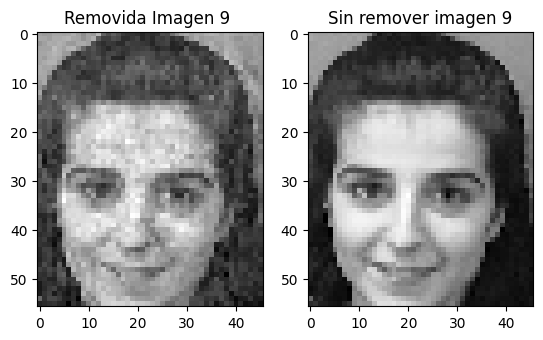

In [111]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(IMG_RESHAPE_RMV, cmap='gray')
axs[0].set_title("Removida Imagen 9 ")

axs[1].imshow(reconstructed_img_2dpca[19], cmap='gray')
axs[1].set_title("Sin remover imagen 9")

plt.savefig("graficos/reconstrucción_removida_2DPCA.svg")
plt.show()